## FINA 4335 with Marius Popescu
## Project 2

### Instructions

    1. Upload your group's notebook to Canvas, and a PDF of your notebook to Gradescope. The PDF must be exported from JupyterLab via File > Save and Export Notebook As… > PDF
    2. Your notebook must be self-contained (i.e., import data from the web via yfinance or pandas datareader and do not rely on other files)
    3. Tips:
        a) Your goal is to convince me of your conclusions
        b) Remove unnecessary data frame printouts.
        c) Remove code that does not serve a purpose.

#### Import the Necessary Libraries

In [248]:
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### PART I

    1. In this question, you will examine the effectiveness of the CAPM model. In order to do this, you will need to download the 'Portfolios_Formed_on_BETA' file from Ken French's website at Dartmouth College. Specifically, you will need to use the third dataset (index [2]), which contains the annual returns on two sets of portfolios formed on the previous year's betas. You will need to use the quintile portfolios (Lo20 through Hi20) for your analysis.
        a. Compute and plot the average annual return for each of the five portfolios. How do you interpret the results?
        b. Compute and plot the value of $1 invested in each of the five portfolios at the end of trading in 1963. How do you interpret the results?
        c. What can you conclude based on the evidence in part a) and part b).

In [249]:
port_beta= pdr.get_data_famafrench('Portfolios_Formed_on_BETA', start=dt.datetime(1900,1,1))[2]
port_beta = port_beta.iloc[:,:5]

In [250]:
#print(port_beta['DESCR'])

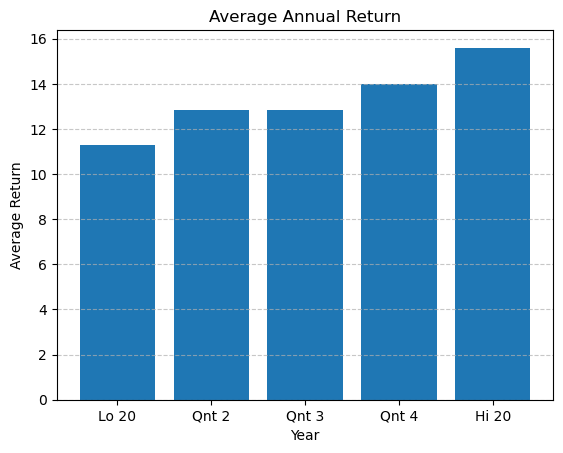

In [251]:
#average annual return across all 5 portfolios
plt.bar(port_beta.columns,port_beta.mean(axis=0))
#port_beta.mean.plot()
plt.title("Average Annual Return")
plt.ylabel("Average Return")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Year");

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20
Date,,,,,
1964,1.787000e+01,2.075000e+01,1.866000e+01,9.730000e+00,1.355000e+01
1965,1.736964e+02,1.655850e+02,3.060240e+02,2.518124e+02,6.865785e+02
1966,-1.432995e+03,-1.849584e+03,-2.478794e+03,-4.356355e+02,-8.238942e+02
1967,-2.067812e+04,-4.265142e+04,-8.167628e+04,-1.907648e+04,-4.296608e+04
1968,-3.475992e+05,-4.316323e+05,-1.195741e+06,-2.943500e+05,-1.084464e+06
...,...,...,...,...,...
2020,1.623893e+61,6.022547e+64,-5.934755e+62,2.872995e+68,1.035308e+72
2021,3.174711e+62,1.795924e+66,-8.824980e+63,1.418110e+70,2.898863e+73
2022,-1.981020e+63,-3.564908e+67,1.219612e+65,-3.341067e+71,-1.122440e+75


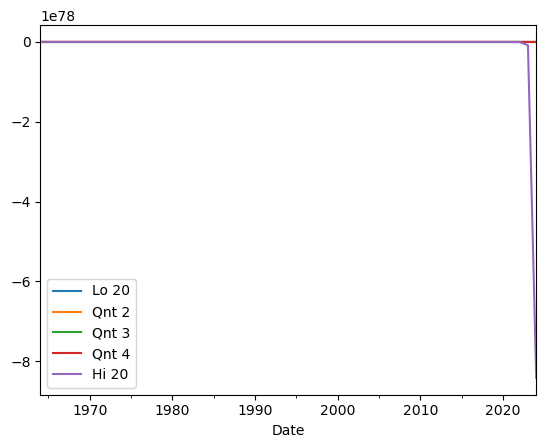

In [274]:
data1963 = port_beta.fillna(0).loc['1963':]

cumulative_value = (1 + data1963).cumprod()
cumulative_value.plot()
cumulative_value

    2. In this question, you will explore the Fama-French SIZE factor. In order to do this, you will need to download the 'Portfolios_Formed_on_ME' file from Ken French's website at Dartmouth College. Specifically, you will need to use the second dataset (index [1]), which contains the monthly returns on two sets of portfolios formed on the previous year's market capitalization . You will need to use the decile portfolios (Lo10 through Hi10) for your analysis.
        a. Create a DF labeled alphas85 to store the intercepts and pvalues from the CAPM model for the ten portfolios over the sample period 1926 - 1985. Create a plot of the intercepts. How do you interpret the results?
        b. Repeat the analysis in part a, but this time using the sample period 1986 - 2024. How do you interpret the results?
        c. What can you conclude based on the evidence in part a) and part b).
        d. Are the returns on the ten portfolios formed on size concentrated in a specific month? Use statistics and plots to justify your answer.

In [214]:
port_me= pdr.get_data_famafrench('Portfolios_Formed_on_ME', start=dt.datetime(1900,1,1))[1]
port_me=port_me.iloc[:,9:]


In [215]:
port_me.index = port_me.index.to_timestamp()
port_me=port_me.resample('ME').last()

In [216]:
ff_factors = pdr.get_data_famafrench('F-F_Research_Data_Factors',start=dt.datetime(1900,1,1))[0]
ff_factors.index = ff_factors.index.to_timestamp(how='end').normalize()

In [217]:
port_me = port_me.join(ff_factors)
port_me

,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
1926-07-31,-1.42,0.29,-0.15,0.88,1.45,1.85,1.63,1.38,3.38,3.29,2.96,-2.56,-2.43,0.22
1926-08-31,4.61,2.59,4.03,3.24,2.66,4.67,1.54,1.63,0.98,3.70,2.64,-1.17,3.82,0.25
1926-09-30,0.91,-1.87,-2.27,-0.84,0.12,-0.07,-1.58,0.64,-0.86,0.67,0.36,-1.40,0.13,0.23
1926-10-31,-4.72,-1.77,-3.36,-5.01,-3.09,-2.71,-3.45,-3.27,-3.47,-2.43,-3.24,-0.09,0.70,0.32
1926-11-30,-0.77,-0.32,-0.29,4.79,3.17,3.58,3.80,2.95,3.61,2.70,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-5.40,-3.51,-3.95,-0.33,-1.35,-1.06,0.91,1.71,1.88,3.06,1.61,-3.55,-1.13,0.48
2024-09-30,-0.89,-1.45,0.60,0.37,1.98,1.38,2.31,2.10,2.50,1.78,1.74,-0.17,-2.59,0.40
2024-10-31,0.35,-0.37,0.02,-1.82,-0.37,-1.38,0.28,-1.15,-0.20,-0.94,-0.97,-1.01,0.89,0.39


In [218]:
port_me_85 = port_me.loc['1926':'1985']
port_me_24 = port_me.loc['1986':]

In [219]:
def capm(data, port):
    data['Excess'] = data[port] - data['RF']
    model = smf.ols('Excess ~ Q("Mkt-RF")', data=data, missing="drop").fit()
    #summary = model.summary(yname = 'MSFT Return', xname = ['Alpha', 'MKTRF Beta'])
    return model

In [220]:
portfolios = ["Lo 10", "Dec 2", "Dec 3", "Dec 4", "Dec 5", "Dec 6", "Dec 7", "Dec 8", "Dec 9", "Hi 10"]
alphas85 = pd.DataFrame(index=portfolios, columns=['alpha', 'p_value'])
alphas24 = pd.DataFrame(index=portfolios, columns=['alpha', 'p_value'])
for port in portfolios:
    model = capm(port_me_85, port)
    model2 = capm(port_me_24, port)
    alphas85.loc[port, 'alpha'] = model.params[0]  # Intercept is alpha
    alphas85.loc[port, 'p_value'] = model.pvalues[0]
    alphas24.loc[port, 'alpha'] = model2.params[0]  # Intercept is alpha
    alphas24.loc[port, 'p_value'] = model2.pvalues[0]

Text(0, 0.5, 'Intercept')

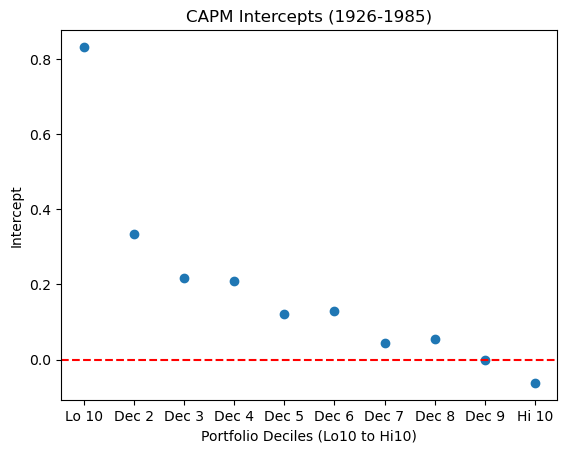

In [221]:
plt.scatter(alphas85.index, alphas85['alpha'].astype(float))
plt.axhline(y=0, color='red', linestyle='--')
plt.title('CAPM Intercepts (1926-1985)')
plt.xticks()
plt.xlabel('Portfolio Deciles (Lo10 to Hi10)')
plt.ylabel('Intercept')

Text(0, 0.5, 'Intercept')

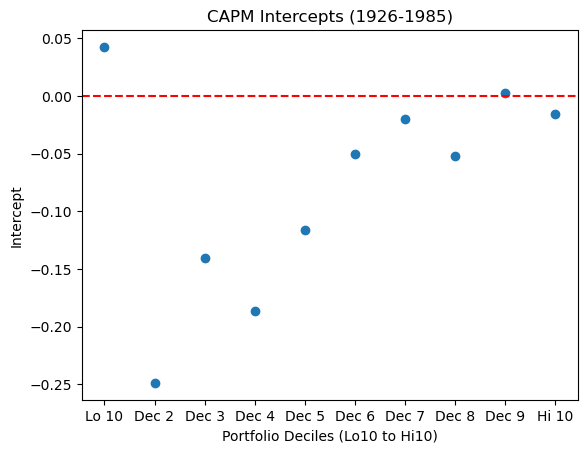

In [222]:
plt.scatter(alphas24.index, alphas24['alpha'].astype(float))
plt.title('CAPM Intercepts (1926-1985)')
plt.axhline(y=0, color='red', linestyle='--')
plt.xticks()
plt.xlabel('Portfolio Deciles (Lo10 to Hi10)')
plt.ylabel('Intercept')

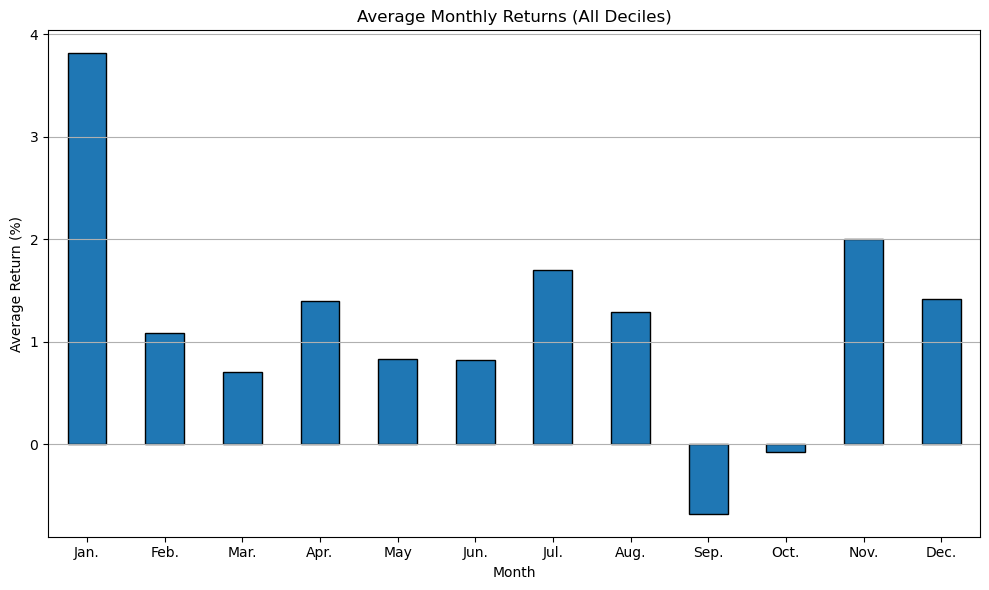

In [223]:
monthly_grouped = port_me.iloc[:,:10].groupby(port_me.index.month)
monthly_avg_returns = monthly_grouped.mean().mean(axis=1)

monthly_avg_returns.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title('Average Monthly Returns (All Deciles)')
plt.xlabel('Month')
plt.ylabel('Average Return (%)')
plt.xticks(ticks=range(12), labels=[
    'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.',
    'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'], rotation=0)
plt.grid(axis='y') 
plt.tight_layout()
plt.show()

### PART II

    3. a. Display the results obtained from applying the Fama-French three-factor model to Berkshire Hathaway's daily returns over its entire history (ticker is 'BRK-A'). What is Berkshire's annualized alpha over its entire history? Comment on Berkshire's portfolio allocation.
    b. Create a DataFrame named coefs to store the coefficient estimates from applying the Fama-French three-factor model to Berkshire Hathaway's returns using a three-year rolling window (Assume there are 250 trading days in a year). Comment on how Berkshire's alpha and betas changed over the past four decades? Use statistics and plots to justify your answer.
    c. What was the most successful 3-year period in Berkshire's history?

### PART III

    4. Implement the following three algorithmic trading strategies, using the monthly market factor from Ken French's website: 
        1) a 12-month SMA strategy (SMA(12)). Specifically, buy the market when the closing price crosses SMA(12) from below and sell it when the closing price crosses SMA(12) from above.
        2) The same strategy as in 1), but this time you can invest in the risk-free asset if you are not invested in the market.
        3) a 12-month SMA strategy where you short sell. Specifically, buy the market when the closing price is above the SMA(12) and sell it when the closing price is below the SMA(12).
    a. Compare these three strategies with a fouth strategy: buying and holding the market. Which was the best performer?
    b. Which of the four strategies was the best investment?
     (Use statistics and plots to justify your answers.) 